# Practica 3. Cuantificacion y codificacion PCM

In [1]:
import numpy as np
import soundfile as sf
import sounddevice as sd  # For playing the audio
import matplotlib.pyplot as plt
from bitarray import bitarray
from bitarray.util import ba2int


audio_path = "/Users/carlosedm10/projects/college/TDSC/Files/vt1.wav"

# 1 Reading file

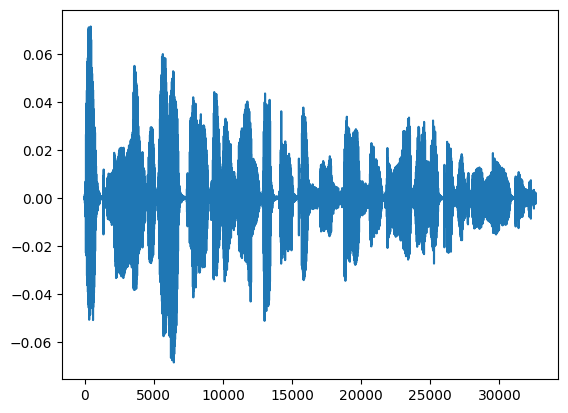

In [2]:
audio, fs = sf.read(audio_path)
plt.plot(audio)
plt.show()

# sd.play(audio, fs)

# 2 Coding and Decoding

Error cuadratico medio: 1.989757130469372e-08


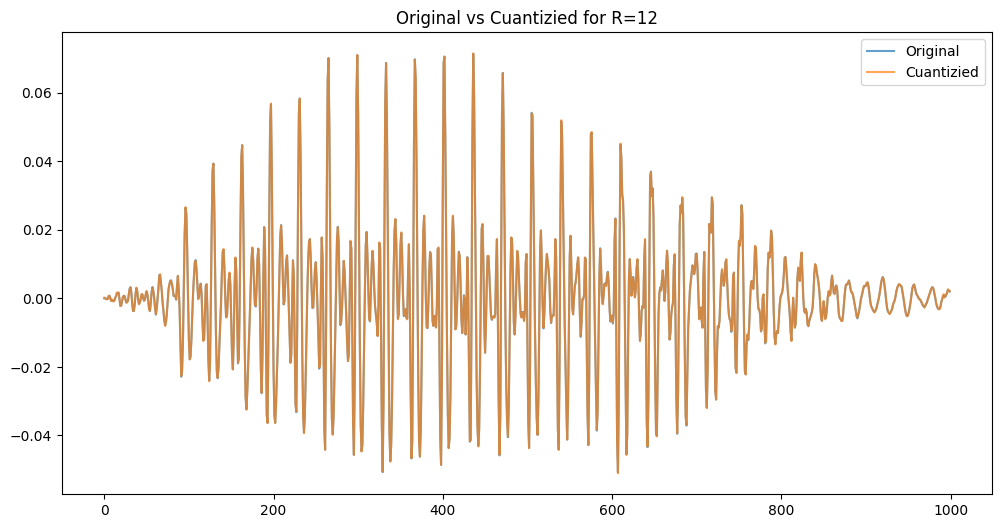

Error cuadratico medio: 6.1649695846153026e-06


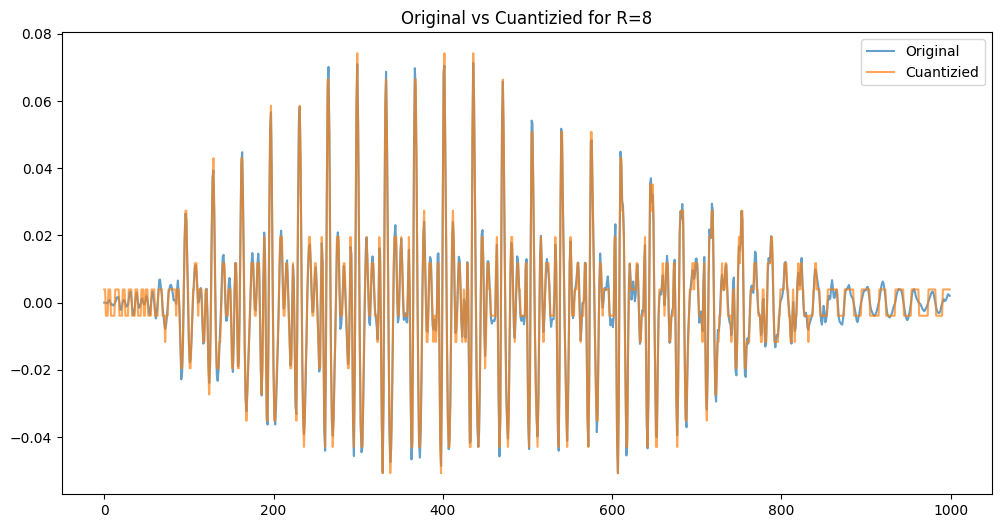

Error cuadratico medio: 0.003126276181743193


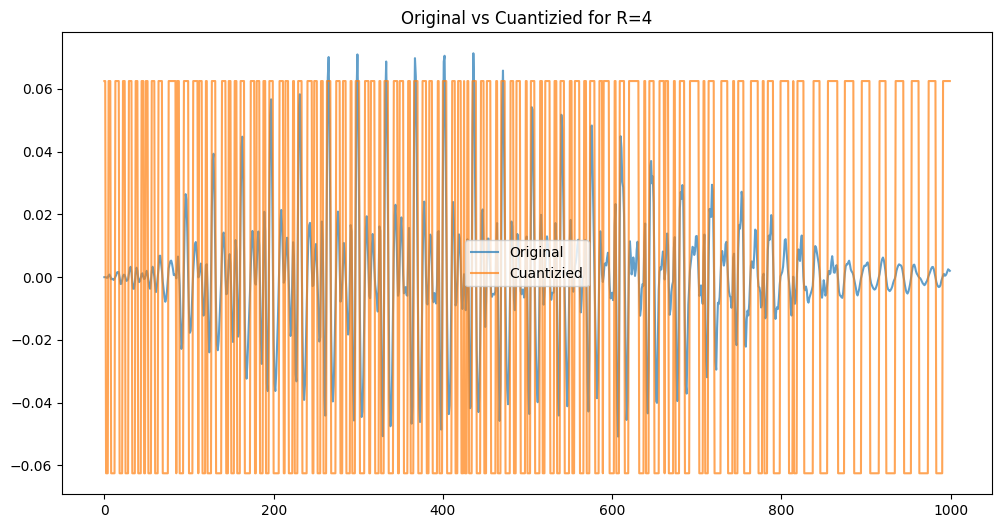

Error cuadratico medio: 0.05901604271449446


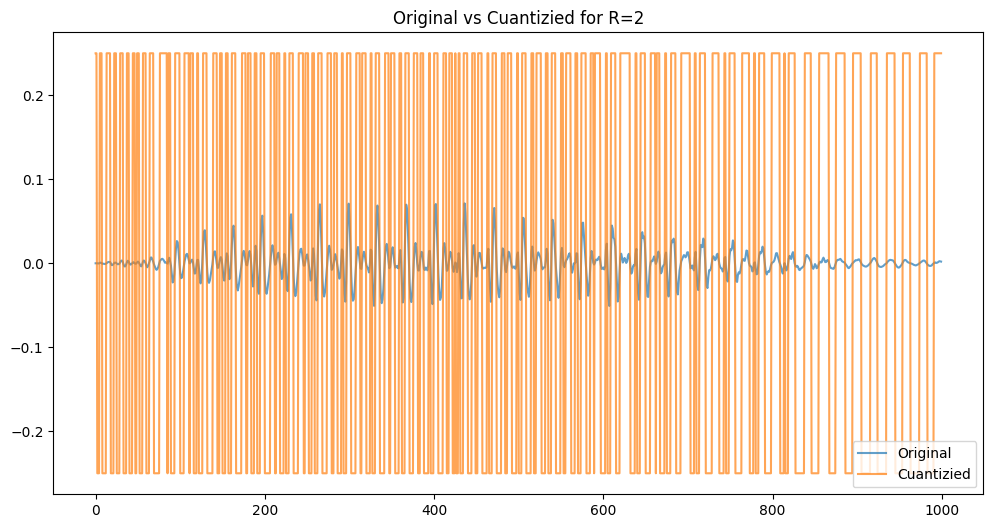

In [3]:
def uniform_coder(audio, R):
    levels = 2**R
    delta = 2 / levels  # Paso de cuantización
    k_index = np.floor((audio + 1) / delta).clip(0, levels - 1)  # Indices cuantizados
    Q = k_index * delta - 1 + delta / 2  # Reconstrucción del valor cuantizado
    return Q, k_index


def decoder(indices, R):
    """
    Reconstruye la señal a partir de los índices de cuantificación.

    Args:
        indices (np.ndarray): Índices de cuantificación.
        niveles (int): Número de niveles de cuantización.

    Returns:
        np.ndarray: Señal decuantificada.
    """
    levels = 2**R
    delta = 2 / levels  # Paso del cuantificador en [-1, 1)
    decuant_audio = indices * delta - 1 + delta / 2
    return decuant_audio


def mean_squared_error(original, reconstruida):
    error = np.mean((original - reconstruida) ** 2)
    return error


for R in [12, 8, 4, 2]:

    cuantified_audio, indexes = uniform_coder(audio, R=R)
    reconstructed_audio = decoder(indexes, R=R)
    error = mean_squared_error(audio, reconstructed_audio)
    print(f"Error cuadratico medio: {error}")
    # sd.play(cuantified_audio, fs)
    # sd.wait()  # Wait until playback finishes

    plt.figure(figsize=(12, 6))
    plt.plot(audio[:1000], label="Original", alpha=0.7)
    plt.plot(cuantified_audio[:1000], label="Cuantizied", alpha=0.7)
    plt.legend()
    plt.title(f"Original vs Cuantizied for R={R}")

    plt.show()

# 3 PCM

Codificación completada. Archivo generado: vt1_4bits.pcm
Decodificación completada. R = 12, N = 32613
Error cuadratico medio: 7.233514728890615e-08


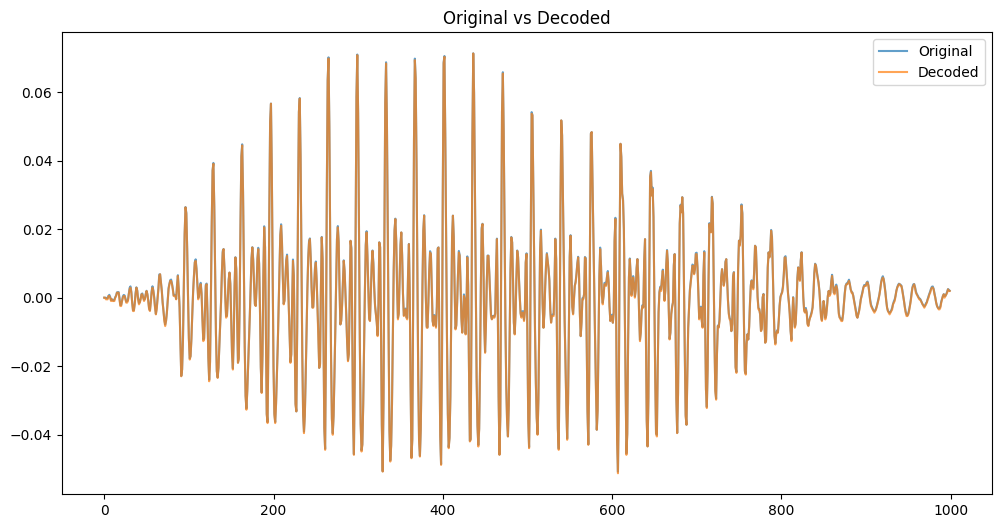

In [6]:
def cod_pcm(audio, R: int, file_name: str):
    """
    Codificador PCM para secuencias de voz de banda estrecha.

    Args:
        x (np.ndarray): Vector con las muestras de la secuencia x[n] a codificar (-1 <= x < 1).
        R (int): Número de bits con el que se codifica cada muestra (1 <= R <= 15).
        file_name (str): Nombre del archivo donde se almacenará la secuencia codificada.
    """
    # Validación de parámetros
    if R < 1 or R > 15:
        raise ValueError("El valor de R debe estar en el rango [1, 15].")
    if np.min(audio) < -1 or np.max(audio) >= 1:
        raise ValueError("La secuencia x[n] debe cumplir -1 <= x[n] < 1.")

    # Cuantización uniforme
    N = len(audio)  # Número de muestras
    levels = 2**R  # Número de niveles de cuantificación
    delta = 2 / levels  # Paso del cuantizador
    k_index = np.floor((audio + 1) / delta).clip(0, levels - 1).astype(int)

    # Generar cabecera
    bitstream = bitarray()
    bitstream.extend(format(R, "04b"))  # R codificado con 4 bits
    bitstream.extend(format(N, "032b"))  # N codificado con 32 bits

    # Codificar índices k' en palabras de R bits
    for idx in k_index:
        bitstream.extend(format(idx, f"0{R}b"))

    # Escritura en archivo binario
    with open(file_name, "wb") as f:
        bitstream.tofile(f)

    print(f"Codificación completada. Archivo generado: {file_name}")


def dec_pcm(file_name: str):
    bit_stream = bitarray(endian="big")
    with open(file_name, "rb") as f:
        bit_stream.fromfile(f)

    R = ba2int(bit_stream[:4])  # First 4 bits: R
    N = ba2int(bit_stream[4:36])  # Next 32 bits: N

    indices = []
    offset = 36
    for _ in range(N):
        index_bits = bit_stream[offset : offset + R]
        if len(index_bits) < R:  # Handle cases where slicing isn't exact
            raise ValueError("Bitstream misalignment detected.")
        indices.append(int(index_bits.to01(), 2))
        offset += R

    levels = 2**R
    delta = 2 / levels
    decoded_audio = np.array(indices) * delta - 1

    print(f"Decodificación completada. R = {R}, N = {N}")
    return decoded_audio


R = int(96 / 8)  # 96 kbps/ 8 kHz
cod_pcm(audio, R, "vt1_4bits.pcm")
decoded_audio = dec_pcm("vt1_4bits.pcm")

sd.play(decoded_audio, fs)

# Error
error = mean_squared_error(audio, decoded_audio)
print(f"Error cuadratico medio: {error}")
plt.figure(figsize=(12, 6))
plt.plot(audio[:1000], label="Original", alpha=0.7)
plt.plot(decoded_audio[:1000], label="Decoded", alpha=0.7)
plt.legend()
plt.title("Original vs Decoded")
plt.show()